In [1]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/drive/MyDrive/DynamicConvolution'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import sys
sys.path.append(root_dir)

In [3]:
from utils.options import Options
import inspect_attention
from inspect_attention import *


experiment_name = "Resnet_DY_05"
epoch = 100

experiment_path = os.path.join(root_dir, "experiments", experiment_name)

opt = Options(config_file_arg="config_path", suppress_parse=True)
opt.load_from_file(os.path.join(experiment_path, "config.yaml"))
opt.experiments = os.path.join(root_dir, "experiments")
opt.checkpoint_path = os.path.join(experiment_path, f"{experiment_name}_{epoch}.pth")

assert opt.use_dynamic

In [4]:
opt.__dict__

{'_config_file_arg': 'config_path',
 'batch_size': 64,
 'checkpoint_path': '/content/drive/MyDrive/DynamicConvolution/experiments/Resnet_DY_05/Resnet_DY_05_100.pth',
 'config_path': '',
 'criterion': 'SmoothNLLLoss',
 'criterion_args': (0.1,),
 'dataset_class': 'TinyImageNet_dataset',
 'device': 'cuda',
 'experiment_name': 'Resnet_DY_05',
 'experiments': '/content/drive/MyDrive/DynamicConvolution/experiments',
 'max_epoch': 100,
 'model_class': 'ResNet10',
 'model_extra_args': (0.5,),
 'nof_kernels': 4,
 'num_workers': 2,
 'optimizer': 'SGD',
 'optimizer_args': (0.1, 0.9, 0, 0.0001),
 'reduce': 4,
 'save_freq': 5,
 'scheduler': 'StepLR',
 'scheduler_args': (30, 0.1),
 'temperature': (30, 1, 10),
 'use_dynamic': True}

In [5]:
model = get_inspect_model(opt)

In [6]:
# train_dl = data.create_data_loader(opt, "train")
# inspect_attention.attentions_register = {}
# test_score = test(model, opt.temperature[1], train_dl, opt.device)
# print("Train score:", test_score)

In [7]:
test_dl = data.create_data_loader(opt, "test")
inspect_attention.attentions_register = {}
test_score = test(model, opt.temperature[1], test_dl, opt.device)
print("Test score:", test_score)

Test score: 0.5392


In [8]:
compute_entropy(inspect_attention.attentions_register)

{'14x14': tensor(1.0643),
 '28x28': tensor(1.2968),
 '56x56': tensor(1.3518),
 '7x7': tensor(1.0041)}

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def to_pandas(register):
  labels = []
  values = []
  for resolution, t_list in register.items():
    t = torch.cat(t_list)
    labels.extend([resolution] * len(t))
    values.extend(torch.distributions.Categorical(t).entropy().tolist())
  return pd.DataFrame({'Resolution': labels, 'Entropy': values})

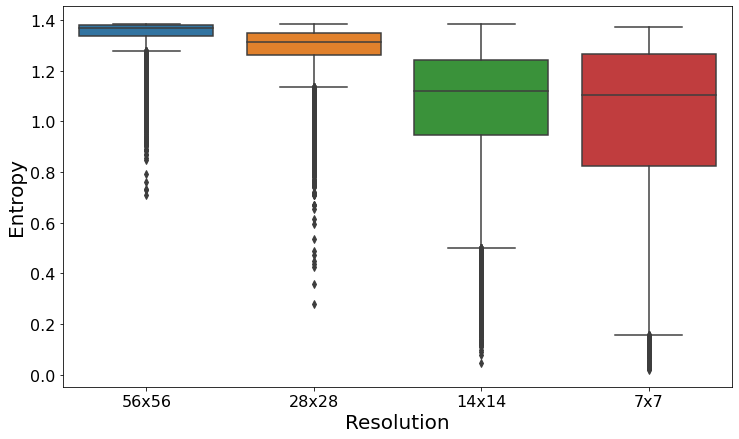

In [10]:
df = to_pandas(inspect_attention.attentions_register)
fig, _ = plt.subplots(figsize = (12, 7))
b = sns.boxplot(data=df, x="Resolution", y="Entropy")

b.set_xlabel("Resolution",fontsize=20)
b.set_ylabel("Entropy",fontsize=20)
b.tick_params(labelsize=16)

In [11]:
fig.savefig("plot.pdf", bbox_inches='tight')